In [1]:
%tensorflow_version 2.x

In [2]:
%matplotlib inline
import os
import pandas as pd
from glob import glob
import numpy as np

In [3]:
!wget https://www.dropbox.com/s/4jw31k5mlzcmgis/genres.tar.gz?dl=0

--2020-12-27 12:19:46--  https://www.dropbox.com/s/4jw31k5mlzcmgis/genres.tar.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/4jw31k5mlzcmgis/genres.tar.gz [following]
--2020-12-27 12:19:46--  https://www.dropbox.com/s/raw/4jw31k5mlzcmgis/genres.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5275a9f491c1c15e1b403f4e3a.dl.dropboxusercontent.com/cd/0/inline/BF1zPTzNf7XAq_8VDXhHyepaEqpBDiL7epW8TzGaL-z3lxEmNQtSCE4YHRy5ylRUUfTmWmDlZk_X0_dm5vgSv04wwKA4UX0tR6n1bEU1TQNGBQ/file# [following]
--2020-12-27 12:19:47--  https://uc5275a9f491c1c15e1b403f4e3a.dl.dropboxusercontent.com/cd/0/inline/BF1zPTzNf7XAq_8VDXhHyepaEqpBDiL7epW8TzGaL-z3lxEmNQtSCE4YHRy5ylRUUfTmWmDlZk_X0_dm5vgSv04wwKA4UX0tR6n1bEU1TQNGBQ/file
Resolvin

In [4]:
import tarfile

In [5]:
data = tarfile.open("genres.tar.gz?dl=0")

In [6]:
data.extractall('./Audiodata')

In [7]:
data.close()

In [8]:
!pip install path

In [9]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import librosa
import librosa.display
import pylab
import matplotlib.pyplot as plt
from matplotlib import figure
import gc
from path import Path

In [10]:
import os
os.mkdir('train')
os.mkdir('test')

In [11]:
# def create_spectrogram(filename,name):
#     plt.interactive(False)
#     clip, sample_rate = librosa.load(filename, sr=None)
#     fig = plt.figure(figsize=[0.72,0.72])
#     ax = fig.add_subplot(111)
#     ax.axes.get_xaxis().set_visible(False)
#     ax.axes.get_yaxis().set_visible(False)
#     ax.set_frame_on(False)
#     S = librosa.feature.melspectrogram(y=clip, sr=sample_rate)
#     librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
#     filename  = '/content/train/' + name + '.jpg'
#     plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
#     plt.close()    
#     fig.clf()
#     plt.close(fig)
#     plt.close('all')
#     del filename,name,clip,sample_rate,fig,ax,S

In [12]:
glob('./train/*')

[]

In [13]:
file_list=list(glob("./Audiodata/genres/blues/*"))

In [14]:
# for i,file in enumerate(file_list):
#     print(i)
#     filename,name = file,file.split('.')[0]
#     create_spectrogram(filename,name)

In [15]:
import IPython.display as ipd


In [16]:
genres = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']

In [17]:
audio_fpath = "/content/Audiodata/genres/blues/"
audio_clips = os.listdir(audio_fpath)

# audio_fpath = "/content/Audiodata/genres/blues/"
# audio_clips_blues = os.listdir(audio_fpath)

print("No. of .wav files in audio folder = ",len(audio_clips))


No. of .wav files in audio folder =  100


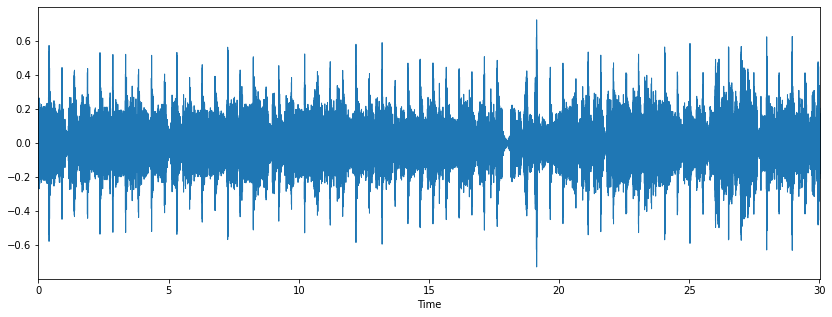

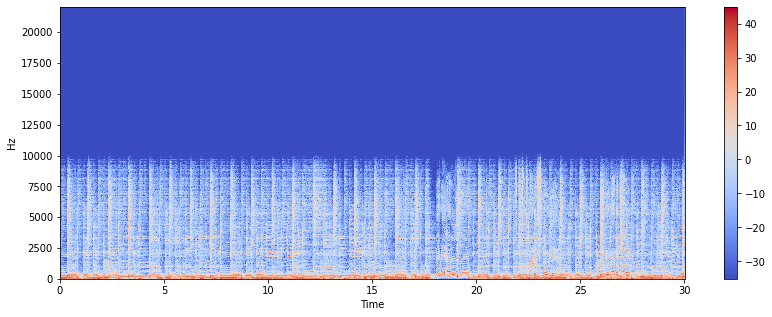

In [18]:
x, sr = librosa.load(audio_fpath+audio_clips[2], sr=44100)
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()


In [19]:
# os.getcwd()
# os.listdir()

In [20]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [21]:
import csv
file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    for filename in os.listdir(f'./Audiodata/genres/{g}'):
        songname = f'./Audiodata/genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rmse(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
data = pd.read_csv('data.csv')
data = data.drop(['filename'],axis=1)
data.head()

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.263129,0.086982,1120.387619,1447.839934,2325.102607,0.047298,-274.288785,130.417424,-6.394800,70.410680,13.265857,9.463105,7.723189,-1.245347,-0.575020,-2.299992,3.783482,0.080915,-0.939682,2.295373,4.290512,-1.661926,-10.444825,-6.797826,-1.068164,-1.596130,blues
1,0.404779,0.141191,1070.119953,1596.333948,2185.028454,0.033309,-199.431144,150.099218,5.647594,26.871927,1.754463,14.238344,-4.830882,9.297965,-0.757741,8.149012,-3.196314,6.087676,-2.476420,-1.073890,-2.874777,0.780976,-3.316932,0.637981,-0.619690,-3.408233,blues
2,0.387851,0.102582,1912.506881,2361.474653,4776.862782,0.058426,-182.638291,90.676797,14.119085,67.549826,2.693214,38.430529,-8.410898,24.127446,-13.781991,4.835996,-16.682031,5.811708,-5.149533,0.192984,-14.480762,6.862884,-4.442362,-2.986889,-4.816248,5.400325,blues
3,0.451905,0.141766,2504.026852,2180.438691,5077.152632,0.167584,-82.454706,94.147763,-27.120917,75.655100,-27.509951,35.576213,-20.278538,25.109201,-15.362310,11.329742,-13.398637,8.139763,-8.494857,8.283361,-10.346549,-3.462061,-5.223508,-2.595848,-8.363733,-6.978243,blues
4,0.265883,0.168145,1513.422107,2140.606779,3449.679140,0.044378,-192.667187,111.190774,21.372723,26.398341,-0.646122,23.486736,-25.464551,16.937731,-16.977055,5.788636,-25.730206,-5.044727,-17.631820,-7.921687,-15.152404,-12.342546,-17.227765,-7.771728,-13.033961,-17.945750,blues


In [23]:
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [24]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train

array([4, 2, 2, 3, 9, 8, 2, 6, 5, 8, 7, 6, 3, 0, 3, 6, 7, 9, 7, 6, 9, 5,
       4, 6, 9, 4, 2, 5, 5, 4, 5, 6, 5, 3, 8, 0, 1, 2, 0, 9, 7, 9, 8, 1,
       9, 7, 5, 4, 5, 6, 1, 0, 5, 7, 3, 0, 4, 2, 7, 6, 3, 7, 6, 8, 7, 0,
       2, 7, 9, 1, 5, 0, 2, 2, 1, 7, 4, 8, 2, 0, 4, 9, 8, 2, 4, 8, 2, 4,
       7, 1, 9, 9, 0, 4, 9, 4, 0, 6, 6, 3, 4, 6, 8, 6, 5, 3, 9, 2, 0, 4,
       4, 1, 6, 2, 9, 8, 1, 4, 7, 7, 8, 3, 0, 1, 3, 9, 0, 3, 3, 4, 1, 4,
       2, 6, 3, 8, 2, 3, 0, 4, 9, 2, 0, 6, 4, 4, 5, 9, 3, 9, 9, 8, 4, 8,
       1, 3, 0, 7, 9, 8, 8, 0, 3, 7, 3, 8, 5, 0, 4, 4, 2, 7, 0, 8, 2, 5,
       3, 1, 9, 9, 3, 9, 4, 4, 3, 3, 0, 1, 7, 6, 3, 1, 0, 3, 7, 3, 3, 8,
       8, 7, 5, 1, 0, 9, 7, 9, 0, 5, 3, 2, 5, 0, 9, 1, 0, 5, 3, 9, 4, 2,
       1, 5, 3, 5, 4, 3, 7, 7, 4, 9, 6, 5, 9, 2, 9, 1, 8, 6, 9, 4, 1, 4,
       0, 8, 9, 2, 8, 0, 1, 5, 4, 3, 5, 7, 0, 6, 7, 8, 1, 7, 8, 2, 4, 7,
       6, 8, 5, 8, 7, 7, 8, 1, 9, 0, 2, 5, 9, 2, 2, 5, 8, 2, 0, 9, 6, 4,
       6, 4, 8, 6, 2, 9, 9, 2, 8, 7, 2, 0, 4, 2, 5,

In [72]:
#Building ANN
from tensorflow.keras.layers import Dense, Activation
model_ann = models.Sequential()
model_ann.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model_ann.add(layers.Dense(128, activation='relu'))
model_ann.add(layers.Dense(64, activation='relu'))
model_ann.add(layers.Dense(10, activation='softmax'))
X_train.shape[1]


26

In [73]:
model_ann.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [79]:
print("Fit model on training data")
history = model_ann.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=20
)


Fit model on training data
Epoch 1/20
7/7 [==============================] - 0s 4ms/step - loss: 0.2046 - accuracy: 0.9550
Epoch 2/20
7/7 [==============================] - 0s 3ms/step - loss: 0.1899 - accuracy: 0.9613
Epoch 3/20
7/7 [==============================] - 0s 3ms/step - loss: 0.1786 - accuracy: 0.9675
Epoch 4/20
7/7 [==============================] - 0s 3ms/step - loss: 0.1702 - accuracy: 0.9750
Epoch 5/20
7/7 [==============================] - 0s 3ms/step - loss: 0.1559 - accuracy: 0.9737
Epoch 6/20
7/7 [==============================] - 0s 3ms/step - loss: 0.1553 - accuracy: 0.9762
Epoch 7/20
7/7 [==============================] - 0s 3ms/step - loss: 0.1467 - accuracy: 0.9775
Epoch 8/20
7/7 [==============================] - 0s 3ms/step - loss: 0.1419 - accuracy: 0.9787
Epoch 9/20
7/7 [==============================] - 0s 3ms/step - loss: 0.1278 - accuracy: 0.9825
Epoch 10/20
7/7 [==============================] - 0s 3ms/step - loss: 0.1315 - accuracy: 0.9850
Epoch 11/20


In [80]:
test_loss, test_acc = model_ann.evaluate(X_test,y_test)
print('test_acc: ',test_acc)
print('test_loss: ',test_loss)

7/7 [==============================] - 0s 2ms/step - loss: 1.0272 - accuracy: 0.6850
test_acc:  0.6850000023841858
test_loss:  1.0271885395050049


In [81]:
predictions = model_ann.predict(X_test)
# np.argmax(predictions[0])
print("Predicted : " ,predictions[0])
print("Actual : ",y_test[0])

Predicted :  [9.4742680e-01 1.2970076e-05 8.1083197e-03 1.3272214e-04 6.3901316e-05
 6.9808387e-03 7.5403703e-03 1.6650459e-07 3.3894987e-04 2.9394984e-02]
Actual :  0
